In [ ]:
import pandas as pd
import numpy as np
import torch
import os 
import sys
from Bio import SeqIO
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, SamplingConfig
from esm.utils.constants.models import ESM3_OPEN_SMALL
from torch_geometric.data import Dataset
from tqdm import tqdm
from huggingface_hub import login
import torch, gc
import pickle
import matplotlib



class StringDB_Dataset(Dataset):
    # esm_model must end in .pt for local model.
    def __init__(self,data_path,fasta_path,esm_model='ESM3_OPEN_SMALL'):
        self.data_path = data_path
        self.fasta_path = fasta_path
        self.esm_model = esm_model
        self.data_cols = self.get_column_names()
        '''
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.drop_duplicates()
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.drop(columns=['Unnamed: 0'])
        '''
    
    def get_column_names(self):
        if os.path.exists(self.data_path):
            with open(self.data_path) as f:
                return f.readline().strip().split('\t')
        else:
            Exception('File not found, check filepath')

    
    def get_esm_embeddings(self,out_dir):
        client = ESM3.from_pretrained(self.esm_model)
        with open(self.fasta_path) as handle:
            iter = 0
            curr_seq = 0
            for record in tqdm(SeqIO.parse(handle, "fasta")):
                label = record.id
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                output_file = os.path.join(out_dir,f"{label}.pt")
                if len(record.seq) > 1024:
                    if len(record.seq) > 4096:
                        continue
                    seq = record.seq[:1024]
                else:
                    seq = record.seq
                
                #if iter % 5 == 0:
                curr_seq += len(str(seq))
                if curr_seq > 4096*2:
                    torch.cuda.empty_cache()
                    gc.collect()
                    curr_seq = len(str(seq))

                protein = ESMProtein(sequence=(str(seq)))
                protein_tensor = client.encode(protein)
                
                #f = open("debug.txt", "a")
                #f.write(f"iter: {iter},{len(str(seq))}\n")
                #f.close()

                output = client.forward_and_sample(protein_tensor, SamplingConfig(return_mean_embedding=True)).mean_embedding.detach().cpu().numpy()
                result = {"label": record.id, "embeddings": output}
                

                torch.save(result,output_file)


    def load_data(self,data_path):
        if os.path.exists(data_path):
            data = pd.read_csv(data_path)
            return data

In [38]:
path = '/mnt/d/data/stitchdb.txt'
fasta_path = '/mnt/d/data/stringdb_seq_human.fa'
local_model = '/mnt/d/data/esm3_sm_open_v1.pt'
out_dir = '/mnt/d/data/stringdb_embeddings'
data = StringDB_Dataset(path,fasta_path,esm_model='esm3_sm_open_v1')
#data.get_esm_embeddings(out_dir)

In [44]:
len(os.listdir(out_dir))

19626

In [39]:
pd.read_csv('./debug.txt',names=['iter','len'])['len']

0          current string length: 429
1          current string length: 203
2         current string length: 1140
3          current string length: 650
4          current string length: 579
                     ...             
42459                             385
42460                             166
42461                            1024
42462                             411
42463                            1024
Name: len, Length: 42464, dtype: object

In [40]:
with open(path, 'r') as file:
    for _ in range(10):
        print(file.readline().strip())

chemical	protein	experimental_direct	experimental_transferred	prediction_direct	prediction_transferred	database_direct	database_transferred	textmining_direct	textmining_transferred	combined_score
CIDm91758680	190486.XAC0787	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC0788	0	0	0	0	0	0	0	187	187
CIDm91758680	190486.XAC1728	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC1855	0	0	0	0	0	0	0	210	210
CIDm91758680	190486.XAC2361	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC2462	0	0	0	0	0	0	0	173	173
CIDm91758680	190486.XAC2928	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC3041	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC3368	0	0	0	0	0	0	0	161	161


In [43]:
path = '/mnt/d/data/stringdb_human.txt'
humanstringdf = pd.read_csv(path,sep=' ')
print(len(humanstringdf))
unique_proteins = humanstringdf['protein1'].unique()
unique_proteins2 = humanstringdf['protein2'].unique()
unique_proteins_all = np.unique(np.concatenate((unique_proteins,unique_proteins2)))
print(len(unique_proteins_all))

matched_proteins = set()
for protein in unique_proteins_all:
    if os.path.exists(os.path.join(out_dir, f"{protein}.pt")):
        matched_proteins.add(protein)

print(f"Number of matched proteins: {len(matched_proteins)}")

1477610
18767
Number of matched proteins: 18694


In [ ]:
len_dict = {}
iter = 0
with open(fasta_path) as handle:
    for i in SeqIO.parse(handle, "fasta"):
        iter += 1
        if len(i.seq) in len_dict:
            len_dict[len(i.seq)] += 1
        else:
            len_dict[len(i.seq)] = 1
        if iter%10000 == 0:
            print("currently at iteration: " +str(iter), end='\r')

In [ ]:
from Bio import SeqIO

fasta_length = sum(1 for _ in SeqIO.parse(fasta_path, "fasta"))
print(f"Length of the fasta file: {fasta_length}")

Length of the fasta file: 19699


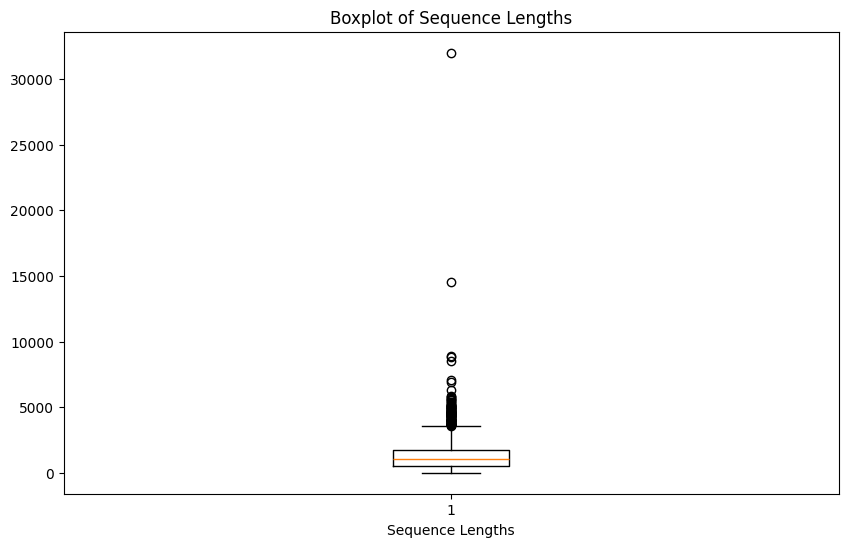

Outliers: [ 4563  4544  3695  4753  4116  4834  4349  4911  4303  4486  5005  4624
  5635  4377  4700  3926  3707  5537  4493  5202  4024  4128  3674  7081
  4684  4707  5142  3708  4374  3907  4646  3957  6907  4022  5038  3859
  5795  5430  3685  4967  8797  4061  5596  4074  3631  4391  5183  3664
  4416  3623  5890  4243  4579  4158  4599  3801  4462  5121  4981 14507
  6306  4861  4857  4069  4265  3661  4588  5058  5412  4012  4439  3972
  5762  5335  4678  8923  3953  4427  3795  5207 32000  4516  4388  3843
  4204  4168  8560  5088  5059  5654  4870  4471  3703  3753  4655  4314
  3616]


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Convert keys to a numpy array
keys_array = list(len_dict.keys())
keys_array = np.array(keys_array)
# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(keys_array)
plt.xlabel('Sequence Lengths')
plt.title('Boxplot of Sequence Lengths')
plt.show()

# Calculate the outliers
Q1 = np.percentile(keys_array, 25)
Q3 = np.percentile(keys_array, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = keys_array[(keys_array < lower_bound) | (keys_array > upper_bound)]
print("Outliers:", outliers)

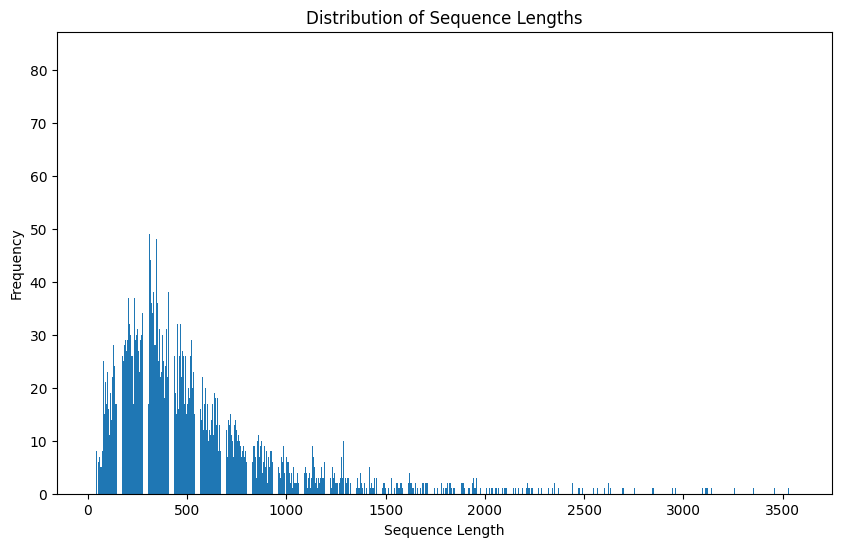

In [ ]:
import matplotlib.pyplot as plt

# Extract keys and values from len_dict
keys = [k for k in len_dict.keys() if k not in outliers]
values = [len_dict[k] for k in keys]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [ ]:
with open('./len_dict_human.pkl', 'wb') as f:
    pickle.dump(len_dict, f)



In [45]:
# old len_dict containing dict of entire database
#pickle.load(open('./len_dict.pkl', 'rb'))